# Reproducing the work of Chen et. al in
# 'Temporal Information Processing on Noisy Quantum Computers'

In [12]:

import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import random_unitary

import QuantumReservoirpy as QRP

from tqdm import tqdm

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

**Initial timeseries simulation**

In [13]:
# Setup of circuits
mem_qubits = [0, 1, 2]
timeseries = [0, 1, 2] * 30 + [0, 1]
ops = [random_unitary(2**len(mem_qubits)) for _ in range(len(np.unique(timeseries)))]


# Backwards horizon (M) needed to cover 95% (r) of all cases
M = 20
r = 0.95

# Dissipation
d =  (1 - r)**(1/M)
print("Dissipation: ", d)

# Number of different circuits (different due to randomness)
SHOTS = 1000
num_subsystems = 50
subsystems = [0] * num_subsystems

n_features = 2**len(mem_qubits)
results = np.zeros((len(timeseries), n_features))

for idx in tqdm(range(num_subsystems)):
    for l in range(1, len(timeseries)):
        qr = QuantumRegister(len(mem_qubits))
        cr = ClassicalRegister(len(mem_qubits))
        circ = QuantumCircuit(qr, cr)
        circ.reset(qr)

        start_idx = max(0, l - 2*M)
        for time in timeseries[start_idx:l]:
            circ.unitary(ops[time], qr, label=f'{time}')
            if np.random.random() > d:
                circ.reset(qr)
        circ.measure(qr, cr)
        
        counts = QRP.utilities._simulate(circ, shots=SHOTS).get_counts()

        for key, val in counts.items():
            bin_to_int = int(key, 2)
            results[l][bin_to_int] += val
        subsystems[idx] = circ

results /= (SHOTS * num_subsystems)
# plt.show()

Dissipation:  0.8608916593317348


 32%|███▏      | 16/50 [01:39<03:31,  6.22s/it]


KeyboardInterrupt: 

**Training phase**

In [ ]:
warmup = 2* M

states = results[:-1]
target = timeseries[1:]

states = states[warmup:]
target = target[warmup:]


model = make_pipeline(StandardScaler(), SVC(gamma='auto'))
train_x, test_x, train_y, test_y = train_test_split(states, target, test_size=0.33)

model.fit(train_x, train_y)
print(f'Score of model: {model.score(test_x, test_y)}')
QRP.utilities.result_plotter(states, target)

**Prediction phase**

In [ ]:
num_predictions = 10
pred_state = results[-1]

temp_series = timeseries[-2*M:]

for p in range(num_predictions):
    pred = model.predict(pred_state.reshape((1, -1)))
    print(pred)
    pred_state *= 0
    for idx in tqdm(range(num_subsystems)):
        # qr = QuantumRegister(len(mem_qubits))
        # cr = ClassicalRegister(len(mem_qubits))
        # circ = QuantumCircuit(qr, cr)
        # circ.reset(qr)

        # for time in temp_series[-2*M:]:
        #     circ.unitary(ops[time], qr, label=f'{time}')
        # circ.measure(qr, cr)
        circ = subsystems[idx]
        time = pred[0]
        circ.unitary(ops[time], mem_qubits, label=f'pred:{time}')
        if np.random.random() > d:
            circ.reset(mem_qubits)
        circ.measure(mem_qubits, mem_qubits)
        # plt.figure()
        # circ.draw('mpl')
        
        counts = QRP.utilities._simulate(circ, shots=SHOTS).get_counts()

        for key, val in counts.items():
            bin_to_int = int(key, 2)
            pred_state[bin_to_int] += val
    pred_state /= (SHOTS * num_subsystems)
    print(pred_state)
print(f"Predictions: {temp_series[2*M:]}")
plt.show()


In [1]:
from QuantumReservoirpy import QReservoir
from QuantumReservoirpy import Layers
from QuantumReservoirpy import utilities

import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, Lasso, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split




In [10]:

M = 100
timeseries = [i for i in range(3)] * 20
reservoir = QReservoir(qubits=5, layers=[
    Layers.OperatorTimeseries(epsilon=1 , M=M)
], num_subcircuits=1)
reservoir.run(timeseries, shots=10000)

  2%|▏         | 1/60 [00:00<00:07,  8.20it/s]

dict_keys([0])
dict_keys([0, 1])


  3%|▎         | 2/60 [00:00<00:12,  4.76it/s]

dict_keys([0, 1, 2])


100%|██████████| 60/60 [26:16:31<00:00, 1576.53s/it]     


array([0.4986, 0.4958, 0.4938, 0.509 , 0.4998, 0.5006, 0.4924, 0.5006,
       0.5032, 0.5022, 0.5067, 0.4996, 0.5026, 0.4923, 0.501 , 0.5003,
       0.498 , 0.4981, 0.4926, 0.4987, 0.4851, 0.5018, 0.5065, 0.5046,
       0.5051, 0.4993, 0.4998, 0.5029, 0.4967, 0.4998, 0.4976, 0.5005,
       0.5046, 0.5026, 0.5019, 0.5025, 0.4995, 0.4943, 0.5081, 0.4978,
       0.4998, 0.4995, 0.4927, 0.4939, 0.5003, 0.4948, 0.501 , 0.4896,
       0.5016, 0.4953, 0.4969, 0.5035, 0.4952, 0.4992, 0.503 , 0.499 ,
       0.5025, 0.5037, 0.5001, 0.5045])

Score of model: 0.35294117647058826


(<Figure size 5000x4000 with 20 Axes>, <Axes: title={'center': 'Feature 20'}>)

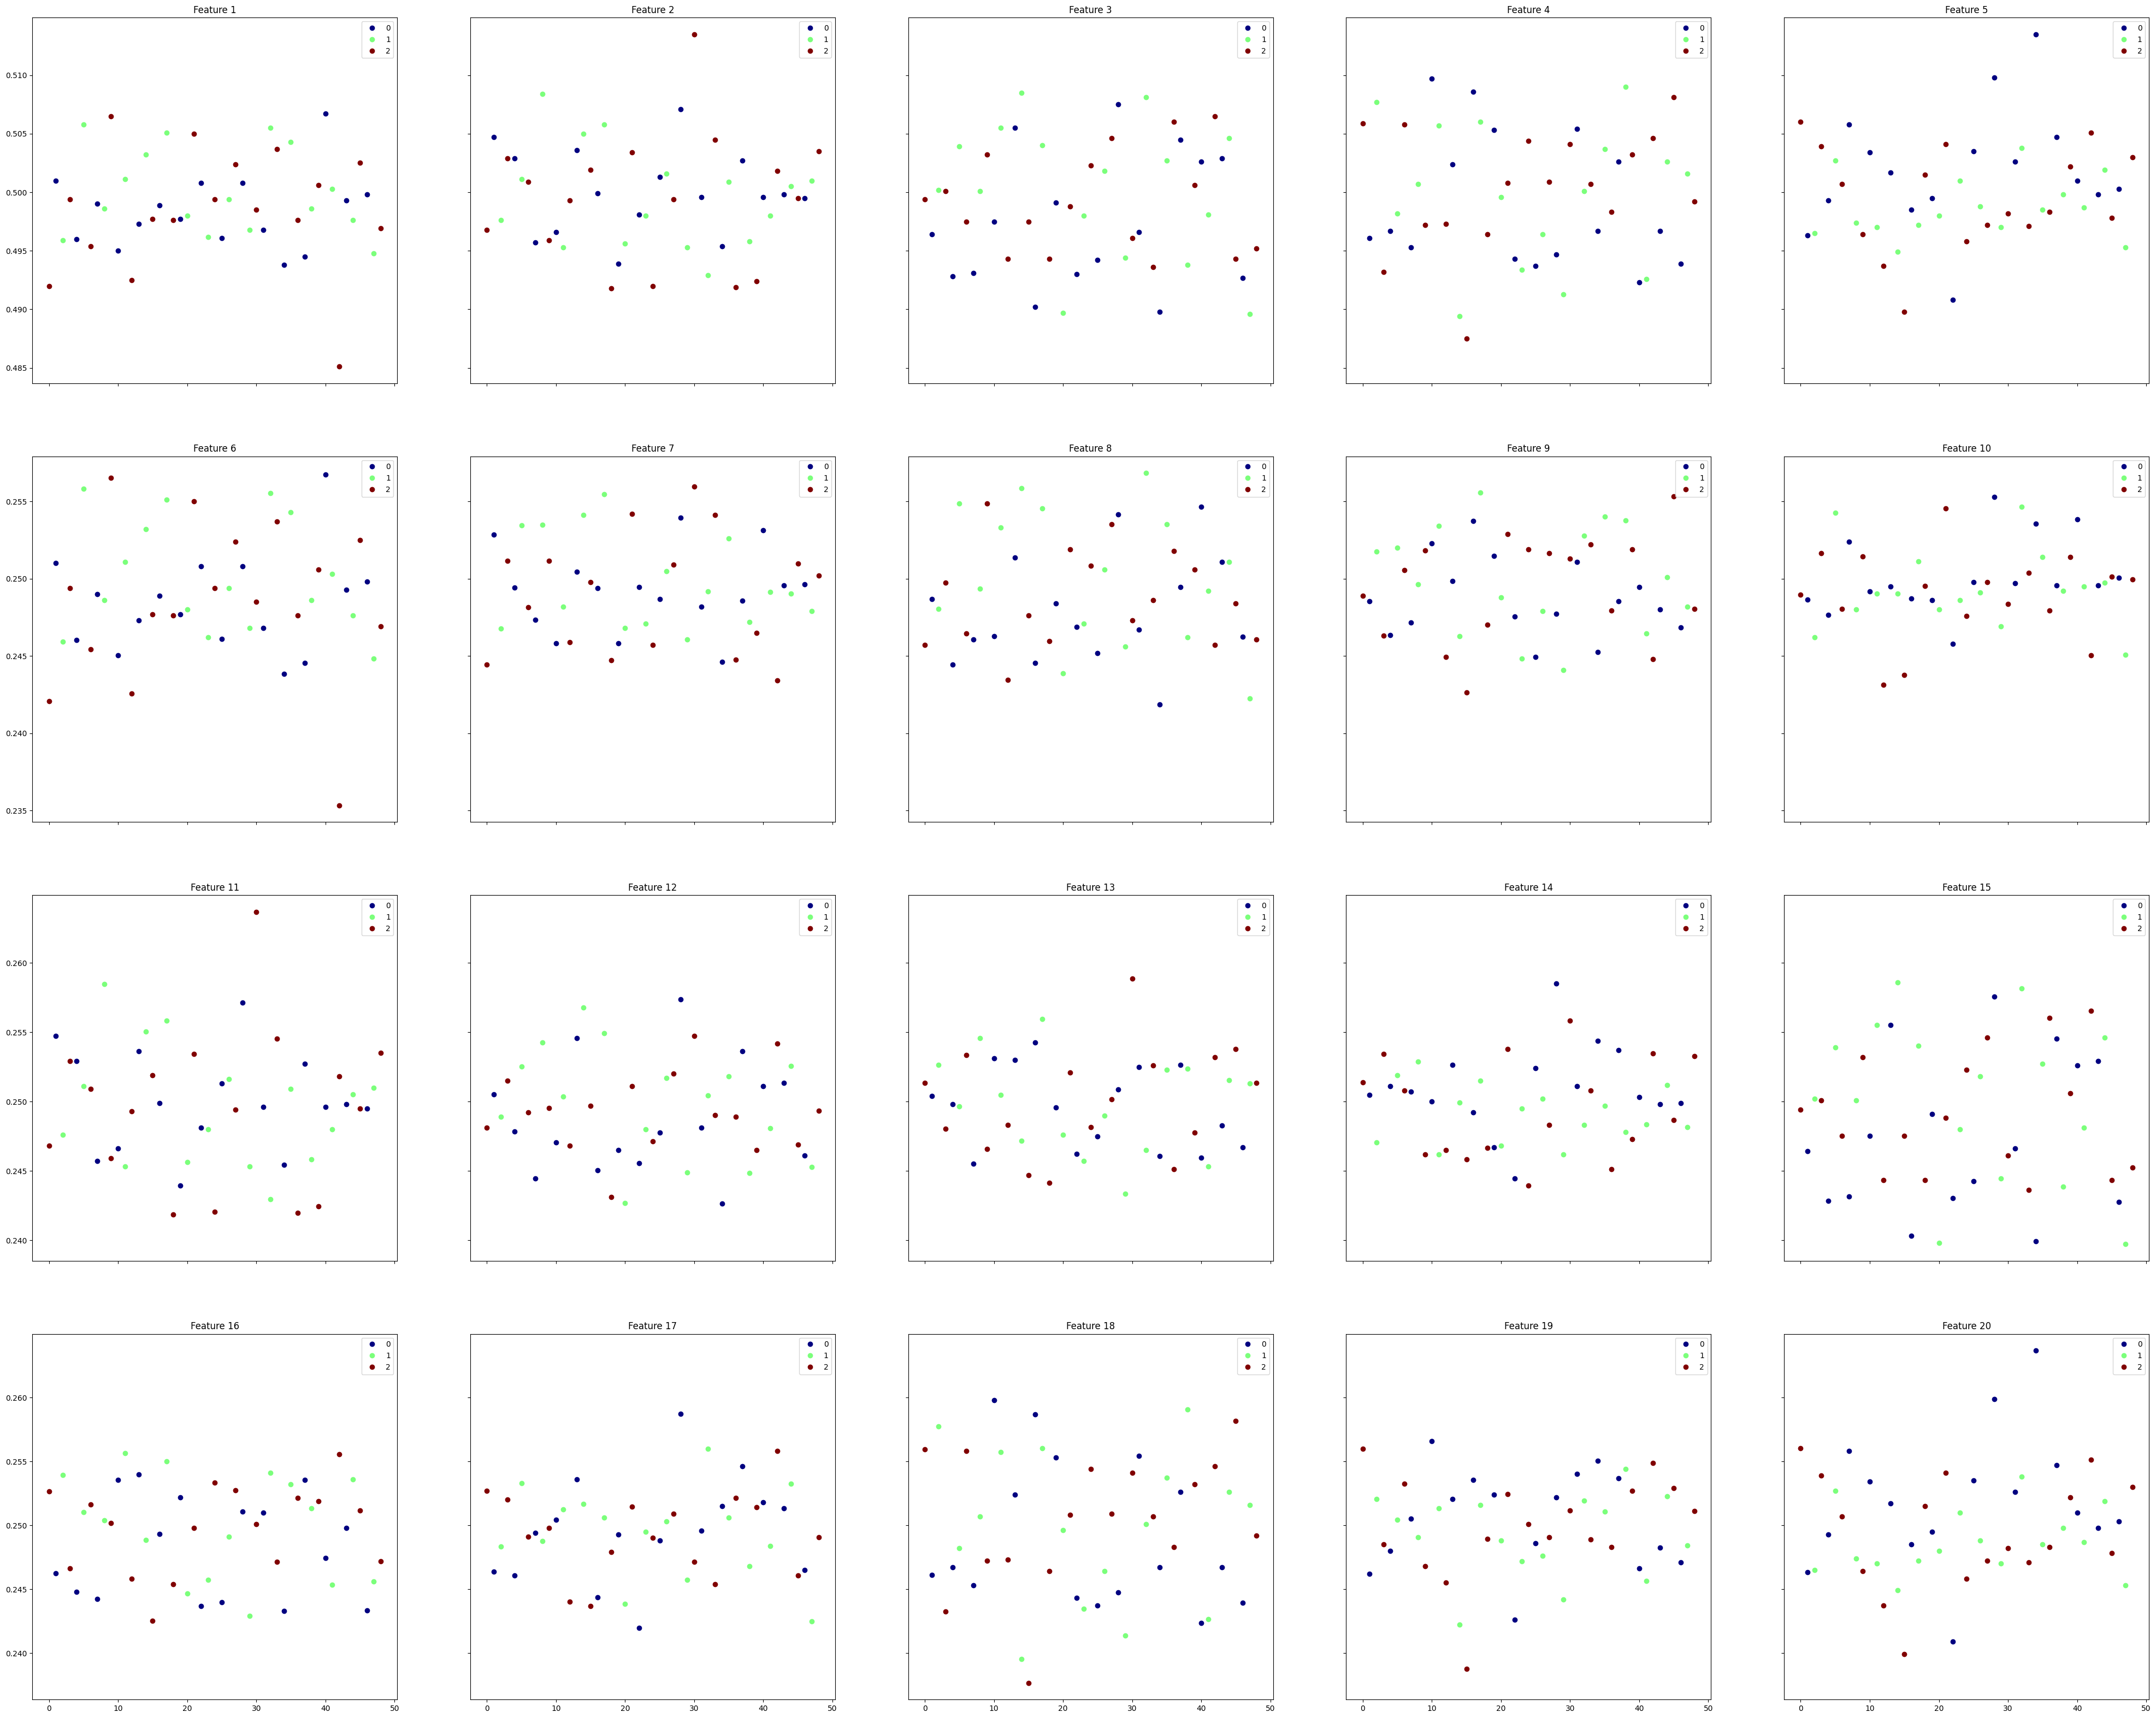

In [11]:


# print(reservoir.states)s
# plt.show()

results = reservoir.states[:-1]
temp = results[-1]
indeces = np.triu_indices(len(temp))
states = np.zeros((len(results), len(temp) + len(indeces[0])))
for i, res in enumerate(results):
    states[i] = np.concatenate((res, np.outer(res.T, res)[indeces]))

target = timeseries[1:]

warmup = 2 * 5
states = states[warmup:]
target = target[warmup:]

model = make_pipeline(StandardScaler(), RidgeClassifier(alpha=1e-2))
model = RidgeClassifier(alpha=1e-2)


train_x, test_x, train_y, test_y = train_test_split(states, target, test_size=0.33)

clf = model.fit(train_x, train_y)
print(f'Score of model: {model.score(test_x, test_y)}')
utilities.result_plotter(states, target)
# plt.show()
# plt.savefig("Beautiful85-1000.pdf")
# reservoir.circuit.draw('mpl')
